In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [5]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [31]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'N1s' : 0.477, 'Ba3d' : 7.49,
            'Cu2p' : 5.321, 'Cl2p' : 0.891, 'Na1s': 1.685, 'Si2p': 0.339})

## Import data

In [4]:
path = '/Users/pabloherrero/sabat/xps_spectra/quartz_FBIG2/2022_05_20_quartz_G2SL_BOLD078_C1/20220520_quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s.xy'
xp = xps_data_import(path)

# Plot raw spectra

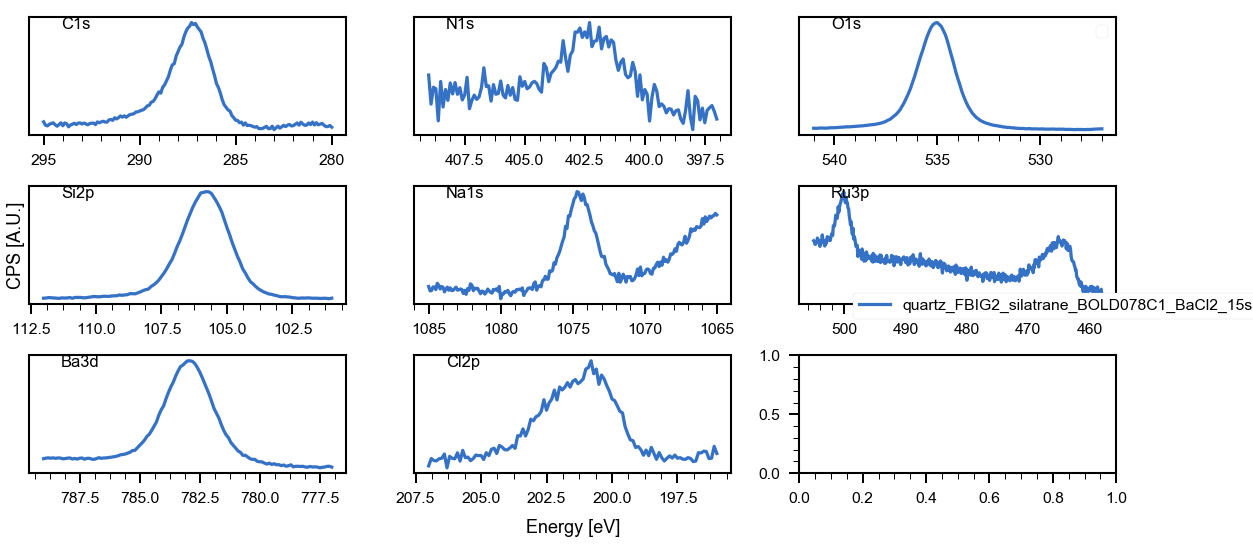

In [9]:
regions = ['C1s', 'N1s', 'O1s', 'Si2p', 'Na1s', 'Ru3p', 'Ba3d', 'Cl2p']
plot_xp_regions([xp], regions, ncols=3);

# BG subtraction

## Bulk subtract background

quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s C1s
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s N1s
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s O1s
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s Si2p
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s Na1s
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s Ru3p
Max iterations exceeded, subtract ALS baseline
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s Ba3d
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s Cl2p


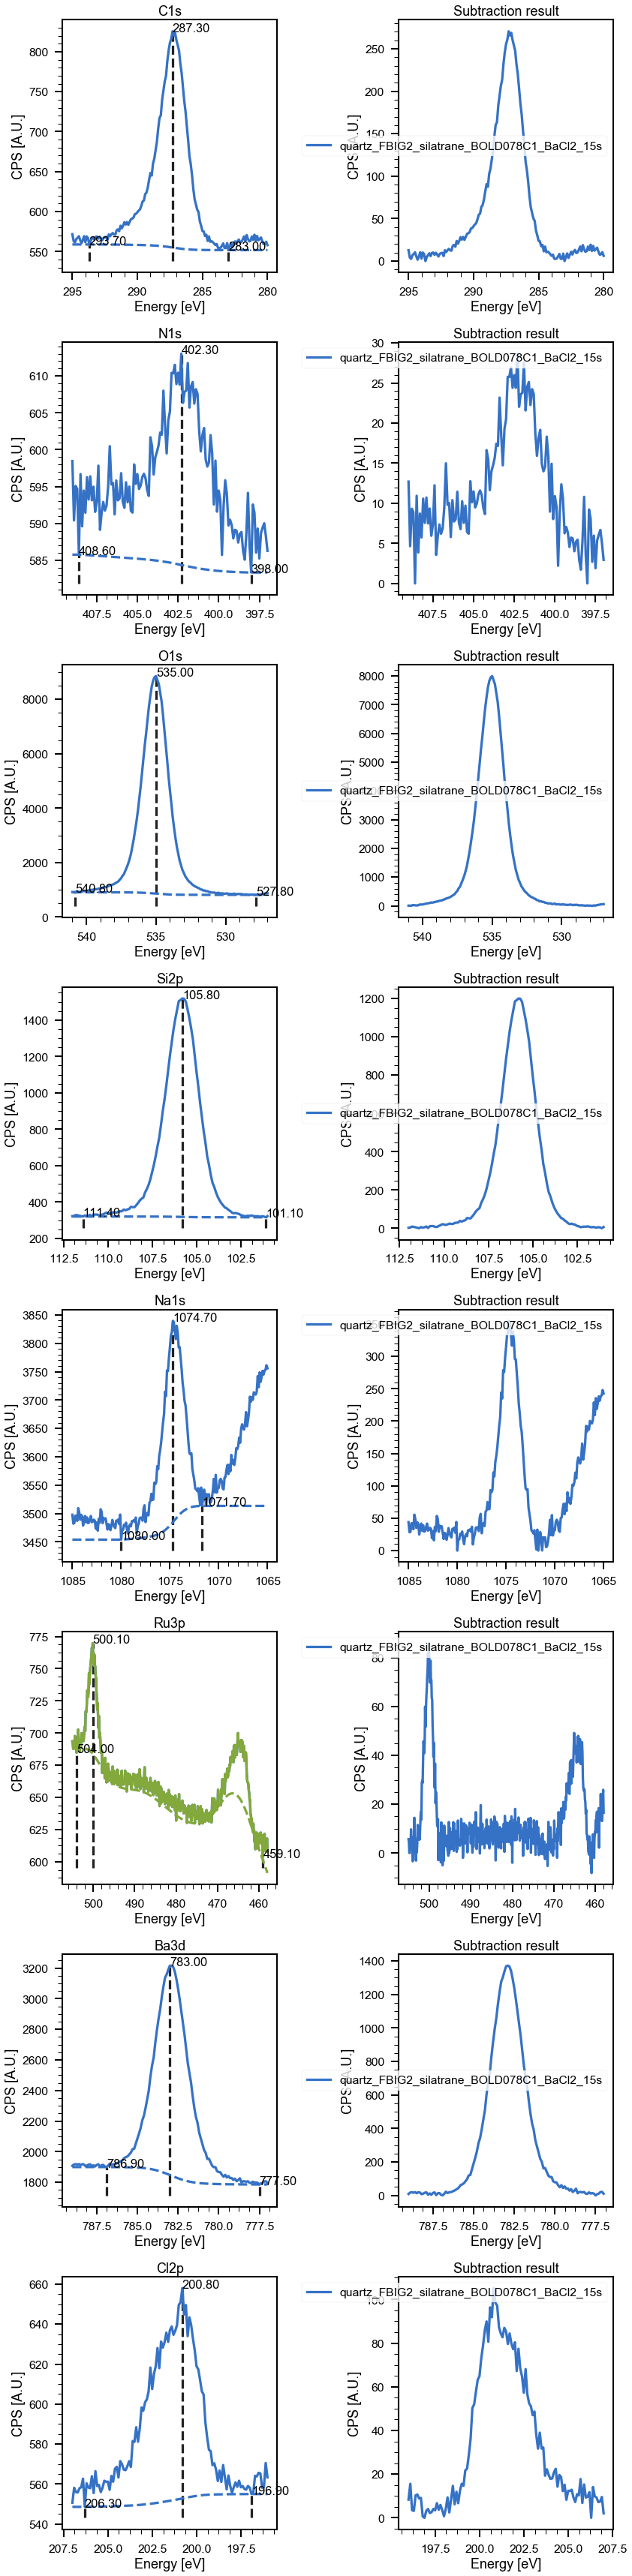

In [15]:
regions = ['C1s', 'N1s', 'O1s', 'Si2p', 'Na1s', 'Ru3p', 'Ba3d', 'Cl2p']
[bg_exps] = bulk_bg_subtract([xp], regions)

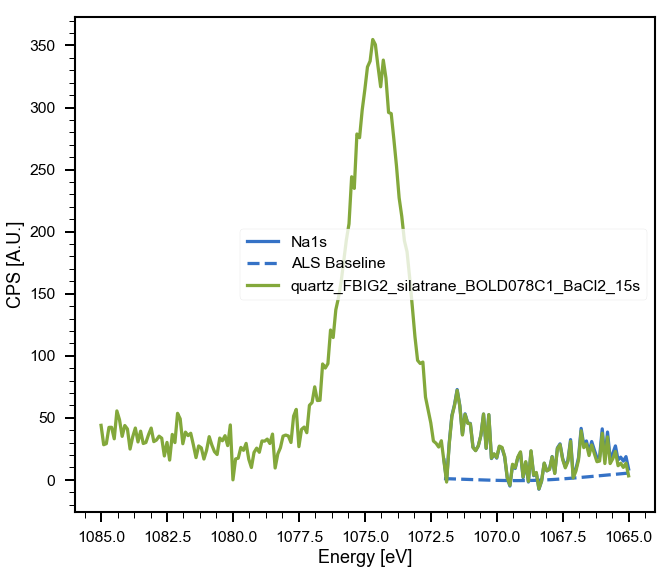

In [36]:
fix_tail_bg(bg_exps, 'Na1s', eup=1072, inplace=True);

## Plot Bg subtraction

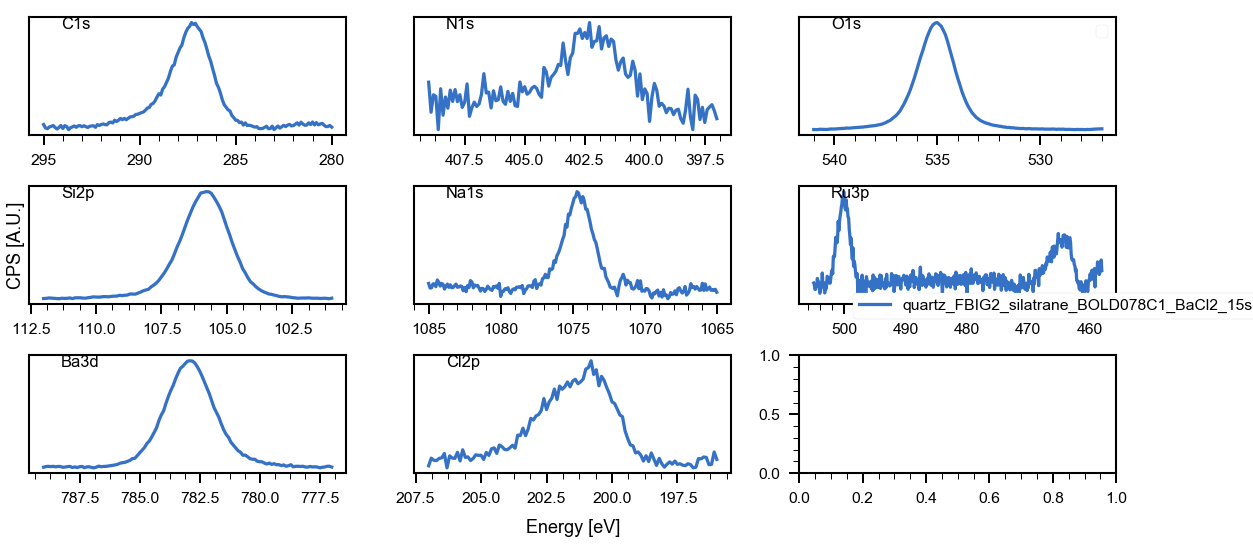

In [18]:
plot_xp_regions([bg_exps], regions, ncols=3);

# Store processed experiments

In [19]:
def store_fits(xp: XPS_experiment, path: str = None):
    """Store fits of a XPS_experiment in separate file"""
    if path == None:
        path = xp.path + '.ft'
    else:
        path += '.ft'
    with open(path, 'w') as fout:
        for k in xp.fit.keys():
            fout.write('XPFit %s:\n\n' %k)
            dump_region = xp.fit[k].dumps()
            fout.write(dump_region + '\n\n')
    print('Storing of file %s successful' %path)
    
def write_processed_xp(filepath : str, xp : XPS_experiment):
    """Save processed XPS experiment to file"""
    import csv;
    with open(filepath, 'w') as fout:
        writer = csv.writer(fout, delimiter='=')
        for att in xp.__dict__.keys():   # Loop over class attributes except dfx (last)
            if (att != 'dfx') and (att != 'ls'):
                writer.writerow([att, getattr(xp, att)])
        writer.writerow(['dfx', ''])
        xp.dfx.to_csv(fout, sep=',')

    if xp.fit != {}: store_fits(xp, filepath)
        
def store_uxy_sxy(bg_exps: list, scaled_exps: list):

    for xpu, xps in zip(bg_exps, scaled_exps):
        filepath, filename = os.path.split(xpu.path)
        filename = os.path.splitext(filename)[0]
        newpath = filepath + '/proc/'
        try:
            os.mkdir(newpath)
        except FileExistsError: pass
        print('Stored ', newpath + filename)
        write_processed_xp(newpath + filename + '.uxy', xpu)
        write_processed_xp(newpath + filename + '.sxy', xps)

In [127]:
store_uxy_sxy(bg_exps, scaled_exps)

Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_06_07_ITO_Ru/proc/20210415_1-qITO_clean
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_06_07_ITO_Ru/proc/20210607_EDI068-qITO_Ru++
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_06_07_ITO_Ru/proc/20210607_EDI068-qITO_Ru++.sxy.ft successful
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_06_07_ITO_Ru/proc/20210607_EDI069-qITO_APTES_Ru++
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_06_07_ITO_Ru/proc/20210607_EDI069-qITO_APTES_Ru++.sxy.ft successful
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_07_08_qITO_Ru_Ir/proc/20210707_ITO_aDEA_EDI_079
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_07_08_qITO_Ru_Ir/proc/20210708_AAN050_EDI076-qITO_APTES_Ir+
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_07_08_qITO_Ru_Ir/proc/20210708_EDI081-qITO_APTES_Ru++
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2021_0

# Stoichiometry

In [25]:
bg_exps.area = {}

'Ru3p' , asf missing, returning raw area
'Ru3p' , asf missing, returning raw area


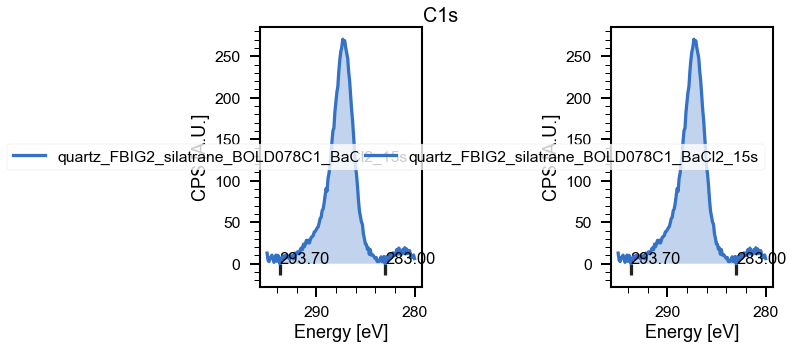

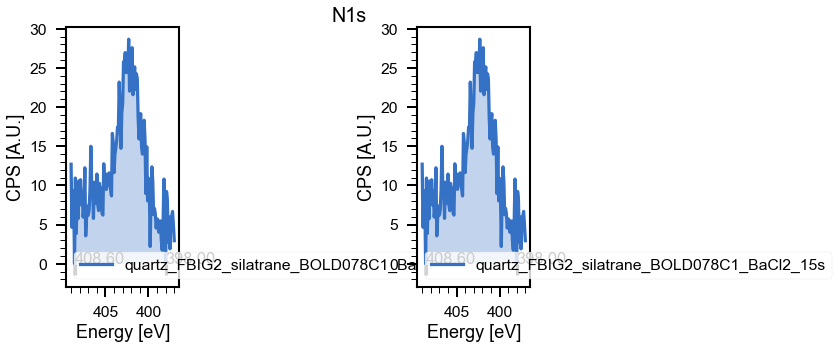

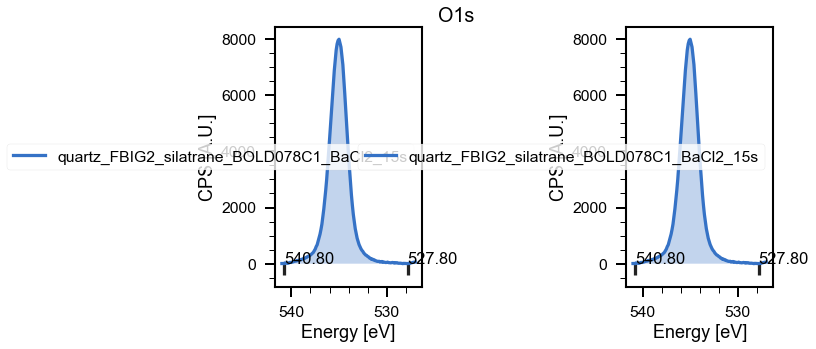

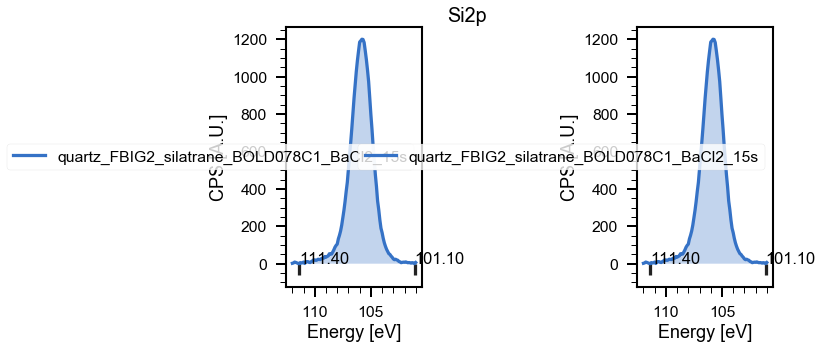

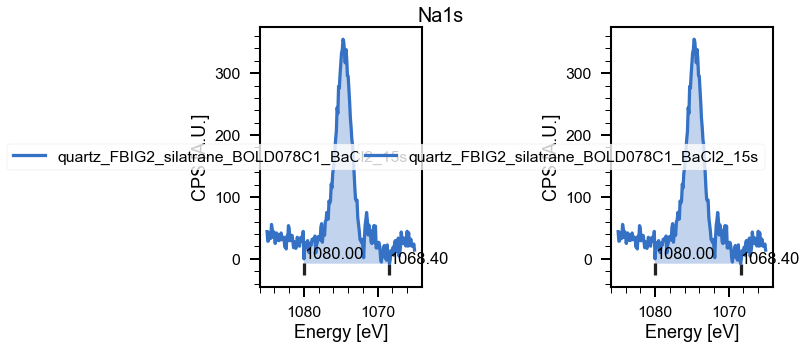

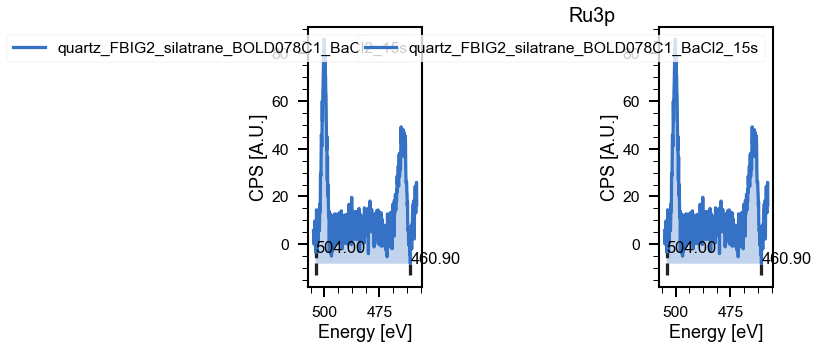

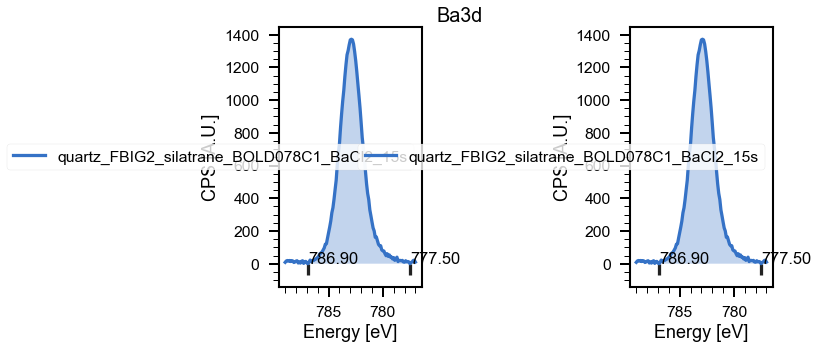

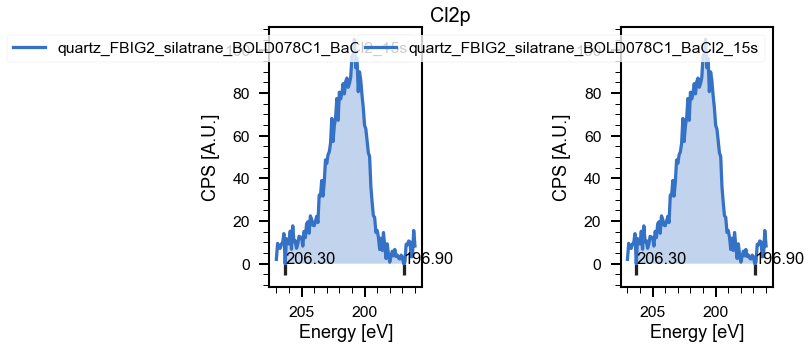

In [32]:
for r in regions:
    integrateRegions([bg_exps, bg_exps], r, asf=asf)

In [33]:
bg_exps.area['FBIG2'] = bg_exps.area['N1s'] / 4

In [34]:
num = ['Na1s', 'Ba3d']
denom = ['FBIG2', 'FBIG2']
display_stoichiometry([bg_exps], num, denom)

In [37]:
num = ['Na1s', 'Ba3d']
denom = ['FBIG2', 'FBIG2']
make_stoichometry_table([bg_exps], num, denom)

Experiment	Na/FBIG	Ba/FBIG	
quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s	9.30 	 6.89 	 


In [39]:
store_uxy_sxy([bg_exps], [bg_exps])

Stored  /Users/pabloherrero/sabat/xps_spectra/quartz_FBIG2/2022_05_20_quartz_G2SL_BOLD078_C1/proc/20220520_quartz_FBIG2_silatrane_BOLD078C1_BaCl2_15s
